# Investment Manager Analysis

This notebook provides a comprehensive analysis of investment managers in the 13F filings data, including manager concentration, behavior patterns, and portfolio characteristics.

## Table of Contents
1. [Manager Overview](#manager-overview)
2. [Manager Concentration Analysis](#concentration)
3. [Portfolio Characteristics](#portfolio)
4. [Manager Behavior Patterns](#behavior)
5. [Top Managers Deep Dive](#top-managers)
6. [Manager Performance Metrics](#performance)
7. [Insights and Conclusions](#insights)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the processed data
print("Loading processed data...")

holdings = pd.read_parquet('../processed_data/combined_holdings.parquet')
managers = pd.read_parquet('../processed_data/manager_summary.parquet')
securities = pd.read_parquet('../processed_data/security_summary.parquet')

print(f"✅ Data loaded successfully!")
print(f"   Holdings: {len(holdings):,} records")
print(f"   Managers: {len(managers):,} records")
print(f"   Securities: {len(securities):,} records")


Loading processed data...
✅ Data loaded successfully!
   Holdings: 4,488,519 records
   Managers: 10,163 records
   Securities: 214,262 records


## 1. Manager Overview {#manager-overview}


In [3]:
# Basic manager statistics
print("=" * 60)
print("INVESTMENT MANAGER OVERVIEW")
print("=" * 60)

# Overall statistics
total_managers = managers['manager_name'].nunique()
total_market_value = managers['total_market_value'].sum()
avg_portfolio_size = managers['total_market_value'].mean()
median_portfolio_size = managers['total_market_value'].median()

print(f"\nOverall Manager Statistics:")
print(f"Total Unique Managers: {total_managers:,}")
print(f"Total Market Value: ${total_market_value/1e12:.2f} trillion")
print(f"Average Portfolio Size: ${avg_portfolio_size/1e9:.2f} billion")
print(f"Median Portfolio Size: ${median_portfolio_size/1e9:.2f} billion")

# Manager size distribution
print(f"\nManager Size Distribution:")
size_bins = [0, 1e6, 10e6, 100e6, 1e9, 10e9, 100e9, float('inf')]
size_labels = ['<1M', '1M-10M', '10M-100M', '100M-1B', '1B-10B', '10B-100B', '>100B']
managers['size_category'] = pd.cut(managers['total_market_value'], bins=size_bins, labels=size_labels, right=False)

size_distribution = managers['size_category'].value_counts().sort_index()
print(size_distribution)


INVESTMENT MANAGER OVERVIEW

Overall Manager Statistics:
Total Unique Managers: 8,079
Total Market Value: $86.99 trillion
Average Portfolio Size: $8.56 billion
Median Portfolio Size: $0.34 billion

Manager Size Distribution:
size_category
<1M          454
1M-10M       194
10M-100M     738
100M-1B     6066
1B-10B      2109
10B-100B     480
>100B        122
Name: count, dtype: int64


ValueError: supplied range of [-inf, 12.742813058906892] is not finite

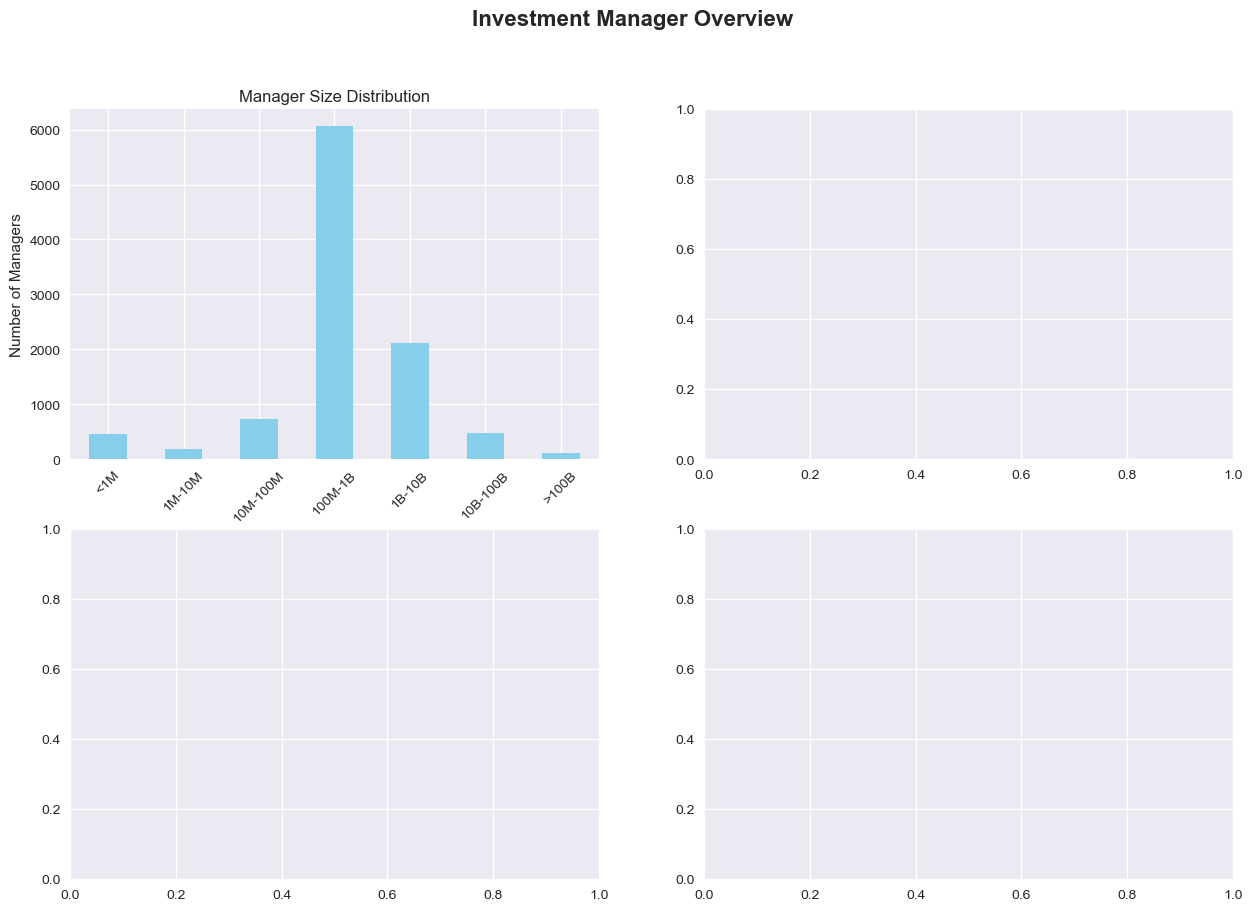

In [4]:
# Manager overview visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Investment Manager Overview', fontsize=16, fontweight='bold')

# Manager size distribution
size_distribution.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Manager Size Distribution')
axes[0,0].set_xlabel('Portfolio Size Category')
axes[0,0].set_ylabel('Number of Managers')
axes[0,0].tick_params(axis='x', rotation=45)

# Portfolio size histogram (log scale)
axes[0,1].hist(np.log10(managers['total_market_value']), bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Portfolio Size Distribution (Log Scale)')
axes[0,1].set_xlabel('Log10(Portfolio Size)')
axes[0,1].set_ylabel('Number of Managers')

# Holdings count distribution
axes[1,0].hist(managers['total_holdings'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Holdings Count Distribution')
axes[1,0].set_xlabel('Number of Holdings')
axes[1,0].set_ylabel('Number of Managers')

# Unique securities distribution
axes[1,1].hist(managers['unique_securities'], bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[1,1].set_title('Unique Securities Distribution')
axes[1,1].set_xlabel('Number of Unique Securities')
axes[1,1].set_ylabel('Number of Managers')

plt.tight_layout()
plt.show()


## 2. Manager Concentration Analysis {#concentration}


In [5]:
# Manager concentration analysis
print("=" * 60)
print("MANAGER CONCENTRATION ANALYSIS")
print("=" * 60)

# Sort managers by market value
managers_sorted = managers.sort_values('total_market_value', ascending=False).reset_index(drop=True)

# Calculate cumulative market value
managers_sorted['cumulative_market_value'] = managers_sorted['total_market_value'].cumsum()
managers_sorted['cumulative_percentage'] = (managers_sorted['cumulative_market_value'] / total_market_value) * 100
managers_sorted['manager_rank'] = range(1, len(managers_sorted) + 1)
managers_sorted['manager_percentage'] = (managers_sorted['manager_rank'] / len(managers_sorted)) * 100

# Top managers analysis
top_10_managers = managers_sorted.head(10)
top_25_managers = managers_sorted.head(25)
top_50_managers = managers_sorted.head(50)
top_100_managers = managers_sorted.head(100)

print(f"\nConcentration Analysis:")
print(f"Top 10 managers control: {top_10_managers['total_market_value'].sum()/1e12:.2f} trillion ({(top_10_managers['total_market_value'].sum()/total_market_value)*100:.1f}%)")
print(f"Top 25 managers control: {top_25_managers['total_market_value'].sum()/1e12:.2f} trillion ({(top_25_managers['total_market_value'].sum()/total_market_value)*100:.1f}%)")
print(f"Top 50 managers control: {top_50_managers['total_market_value'].sum()/1e12:.2f} trillion ({(top_50_managers['total_market_value'].sum()/total_market_value)*100:.1f}%)")
print(f"Top 100 managers control: {top_100_managers['total_market_value'].sum()/1e12:.2f} trillion ({(top_100_managers['total_market_value'].sum()/total_market_value)*100:.1f}%)")

# Display top 10 managers
print(f"\nTop 10 Investment Managers:")
display(top_10_managers[['manager_name', 'total_market_value', 'total_holdings', 'unique_securities', 'avg_holding_value']].round(2))


MANAGER CONCENTRATION ANALYSIS

Concentration Analysis:
Top 10 managers control: 28.52 trillion (32.8%)
Top 25 managers control: 40.90 trillion (47.0%)
Top 50 managers control: 52.04 trillion (59.8%)
Top 100 managers control: 61.60 trillion (70.8%)

Top 10 Investment Managers:


,manager_name,total_market_value,total_holdings,unique_securities,avg_holding_value
0,VANGUARD GROUP INC,5.531120e+12,16744,4280,3.303344e+08
1,MORGAN STANLEY,5.497266e+12,181250,9110,3.032975e+07
2,"BlackRock, Inc.",4.761025e+12,50390,5384,9.448353e+07
3,STATE STREET CORP,2.668089e+12,4260,4260,6.263119e+08
4,STATE STREET CORP,2.426677e+12,4281,4281,5.668481e+08
5,FMR LLC,1.773289e+12,13187,5322,1.344725e+08
6,FMR LLC,1.566306e+12,12998,5285,1.205036e+08
7,MORGAN STANLEY,1.535087e+12,44865,8088,3.421569e+07
8,Legal & General Group Plc,1.390387e+12,30259,3777,4.594953e+07
9,JPMORGAN CHASE & CO,1.369490e+12,33562,7296,4.080479e+07


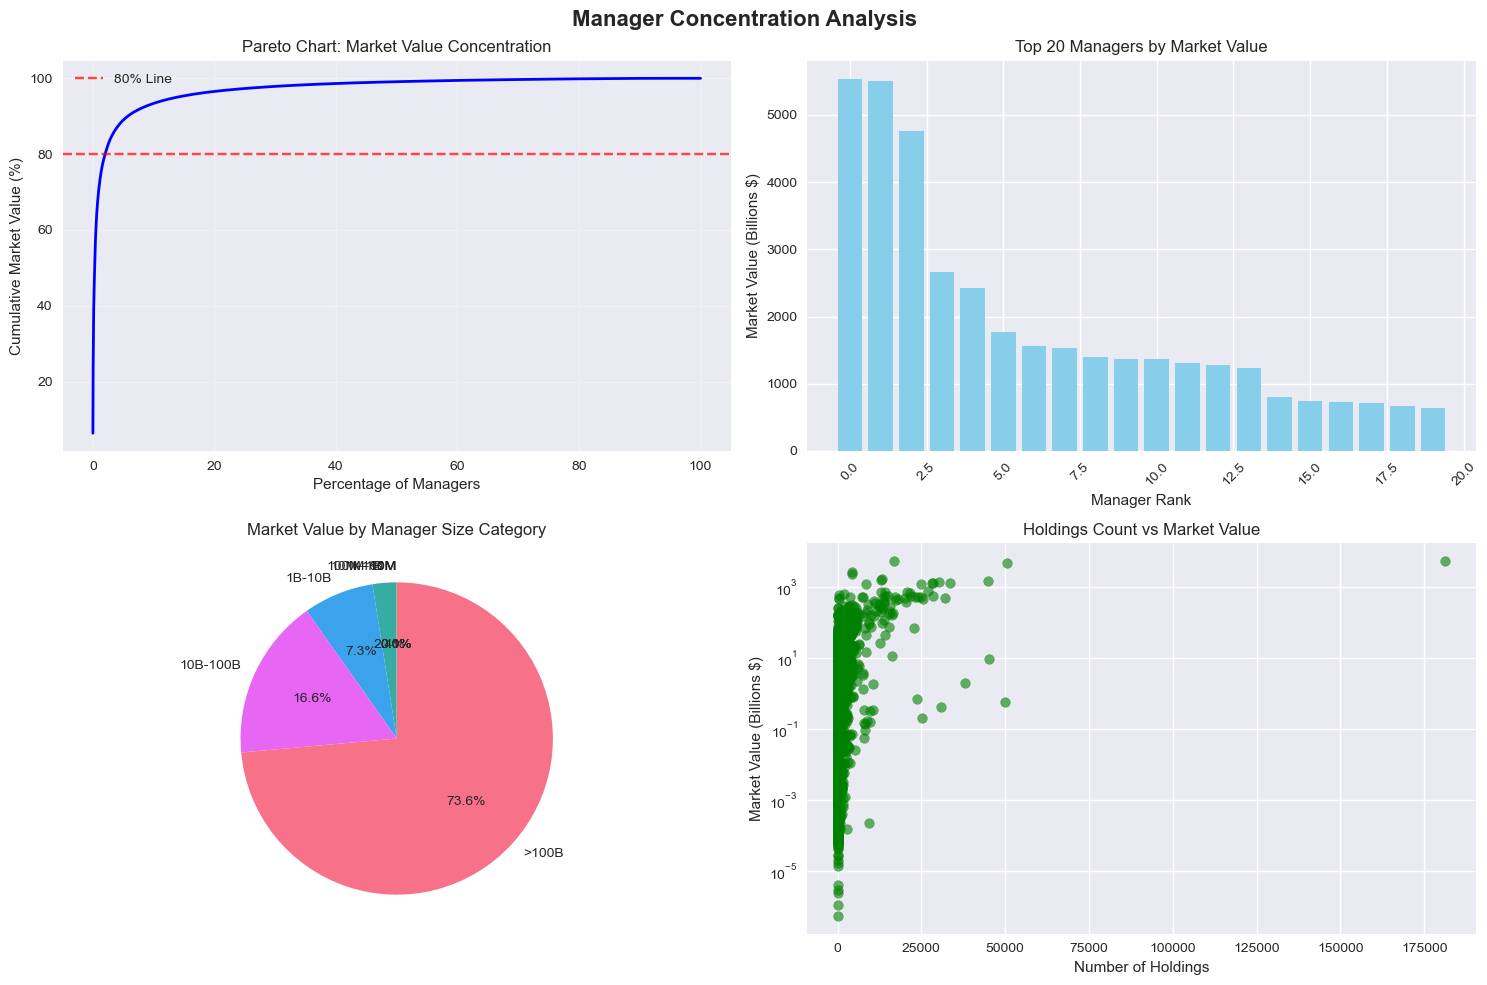

In [6]:
# Concentration visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Manager Concentration Analysis', fontsize=16, fontweight='bold')

# Pareto chart - cumulative market value
axes[0,0].plot(managers_sorted['manager_percentage'], managers_sorted['cumulative_percentage'], 'b-', linewidth=2)
axes[0,0].axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% Line')
axes[0,0].set_title('Pareto Chart: Market Value Concentration')
axes[0,0].set_xlabel('Percentage of Managers')
axes[0,0].set_ylabel('Cumulative Market Value (%)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Top 20 managers bar chart
top_20 = managers_sorted.head(20)
axes[0,1].bar(range(len(top_20)), top_20['total_market_value']/1e9, color='skyblue')
axes[0,1].set_title('Top 20 Managers by Market Value')
axes[0,1].set_xlabel('Manager Rank')
axes[0,1].set_ylabel('Market Value (Billions $)')
axes[0,1].tick_params(axis='x', rotation=45)

# Concentration by size category
concentration_by_size = managers.groupby('size_category')['total_market_value'].sum()
axes[1,0].pie(concentration_by_size.values, labels=concentration_by_size.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Market Value by Manager Size Category')

# Holdings vs Market Value scatter
axes[1,1].scatter(managers['total_holdings'], managers['total_market_value']/1e9, alpha=0.6, color='green')
axes[1,1].set_title('Holdings Count vs Market Value')
axes[1,1].set_xlabel('Number of Holdings')
axes[1,1].set_ylabel('Market Value (Billions $)')
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()


## 3. Portfolio Characteristics {#portfolio}


In [7]:
# Portfolio characteristics analysis
print("=" * 60)
print("PORTFOLIO CHARACTERISTICS ANALYSIS")
print("=" * 60)

# Calculate portfolio diversification metrics
managers['diversification_ratio'] = managers['unique_securities'] / managers['total_holdings']
managers['avg_position_size'] = managers['total_market_value'] / managers['total_holdings']
managers['concentration_ratio'] = 1 / managers['diversification_ratio']  # Higher = more concentrated

# Portfolio characteristics summary
portfolio_stats = managers[['total_market_value', 'total_holdings', 'unique_securities', 
                           'diversification_ratio', 'avg_position_size', 'concentration_ratio']].describe()

print("\nPortfolio Characteristics Summary:")
display(portfolio_stats.round(2))

# Analyze portfolio characteristics by size category
size_analysis = managers.groupby('size_category').agg({
    'diversification_ratio': ['mean', 'median', 'std'],
    'avg_position_size': ['mean', 'median', 'std'],
    'concentration_ratio': ['mean', 'median', 'std'],
    'total_holdings': ['mean', 'median', 'std']
}).round(2)

print("\nPortfolio Characteristics by Manager Size:")
display(size_analysis)


PORTFOLIO CHARACTERISTICS ANALYSIS

Portfolio Characteristics Summary:


,total_market_value,total_holdings,unique_securities,diversification_ratio,avg_position_size,concentration_ratio
count,1.016300e+04,10163.00,10163.00,10163.00,1.016300e+04,10163.00
mean,8.559166e+09,441.65,266.14,0.94,4.886437e+07,1.18
std,1.118127e+11,2614.58,657.38,0.16,9.261375e+08,1.05
min,0.000000e+00,1.00,1.00,0.02,0.000000e+00,1.00
25%,1.514627e+08,32.00,31.00,1.00,1.727434e+06,1.00
50%,3.361200e+08,92.00,87.00,1.00,4.115178e+06,1.00
75%,1.118143e+09,230.00,207.00,1.00,1.521950e+07,1.00
max,5.531120e+12,181250.00,22167.00,1.00,7.930138e+10,44.63



Portfolio Characteristics by Manager Size:


diversification_ratio              avg_position_size  \
                               mean median   std              mean   
size_category                                                        
<1M                            0.98   1.00  0.10      2.337676e+04   
1M-10M                         0.96   1.00  0.10      7.000000e+05   
10M-100M                       0.96   1.00  0.13      8.892524e+06   
100M-1B                        0.96   1.00  0.13      1.612375e+07   
1B-10B                         0.91   1.00  0.19      7.855317e+07   
10B-100B                       0.82   0.99  0.24      4.290702e+08   
>100B                          0.53   0.41  0.31      1.677912e+08   

                                         concentration_ratio               \
                    median           std                mean median   std   
size_category                                                               
<1M                2756.07  8.339696e+04                1.06   1.00  0.52   
1M-10M            21159.30  1.730414e+06                1.06   1.00  0.17   
10M-100M        2260857.65  1.629941e+07                1.10   1.00  0.56   
100M-1B         3321800.94  5.336367e+07                1.12   1.00  0.97   
1B-10B         12513929.74  2.649234e+08                1.25   1.00  1.09   
10B-100B       25453954.68  4.200755e+09                1.55   1.01  1.68   
>100B          40629289.16  3.642919e+08                2.88   2.47  2.34   

              total_holdings                    
                        mean  median       std  
size_category                                   
<1M                   177.22    55.0   1141.07  
1M-10M                302.64   103.5    450.60  
10M-100M              201.37    27.0    699.37  
100M-1B               177.27    82.0    955.34  
1B-10B                467.05   193.0   1469.00  
10B-100B             1622.16   932.5   2258.03  
>100B               11162.23  5821.0  18353.25

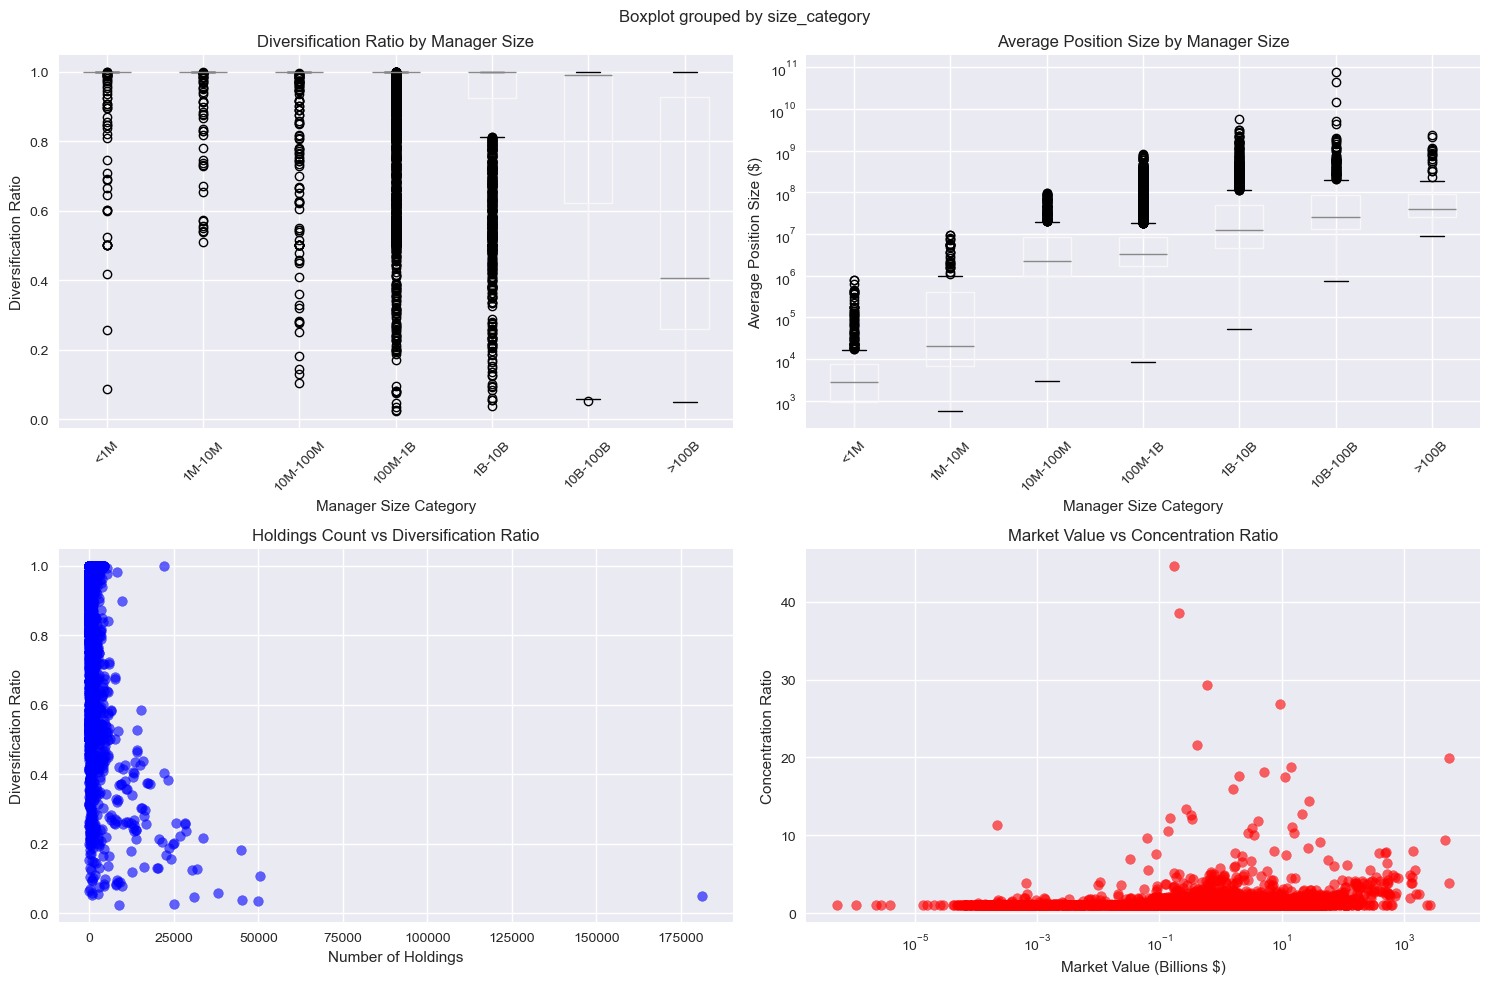

In [8]:
# Portfolio characteristics visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Portfolio Characteristics Analysis', fontsize=16, fontweight='bold')

# Diversification ratio by size category
managers.boxplot(column='diversification_ratio', by='size_category', ax=axes[0,0])
axes[0,0].set_title('Diversification Ratio by Manager Size')
axes[0,0].set_xlabel('Manager Size Category')
axes[0,0].set_ylabel('Diversification Ratio')
axes[0,0].tick_params(axis='x', rotation=45)

# Average position size by size category
managers.boxplot(column='avg_position_size', by='size_category', ax=axes[0,1])
axes[0,1].set_title('Average Position Size by Manager Size')
axes[0,1].set_xlabel('Manager Size Category')
axes[0,1].set_ylabel('Average Position Size ($)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_yscale('log')

# Holdings vs Diversification scatter
axes[1,0].scatter(managers['total_holdings'], managers['diversification_ratio'], alpha=0.6, color='blue')
axes[1,0].set_title('Holdings Count vs Diversification Ratio')
axes[1,0].set_xlabel('Number of Holdings')
axes[1,0].set_ylabel('Diversification Ratio')

# Market value vs Concentration scatter
axes[1,1].scatter(managers['total_market_value']/1e9, managers['concentration_ratio'], alpha=0.6, color='red')
axes[1,1].set_title('Market Value vs Concentration Ratio')
axes[1,1].set_xlabel('Market Value (Billions $)')
axes[1,1].set_ylabel('Concentration Ratio')
axes[1,1].set_xscale('log')

plt.tight_layout()
plt.show()


## 4. Top Managers Deep Dive {#top-managers}


In [9]:
# Deep dive into top managers
print("=" * 60)
print("TOP MANAGERS DEEP DIVE")
print("=" * 60)

# Get top 20 managers
top_20_managers = managers_sorted.head(20)

# Analyze their holdings in detail
top_manager_holdings = holdings[holdings['manager_name'].isin(top_20_managers['manager_name'])]

# Security type preferences of top managers
top_manager_security_prefs = top_manager_holdings.groupby(['manager_name', 'security_type'])['market_value'].sum().unstack(fill_value=0)
top_manager_security_prefs_pct = top_manager_security_prefs.div(top_manager_security_prefs.sum(axis=1), axis=0) * 100

print("\nTop 20 Managers Security Type Preferences (% of portfolio):")
display(top_manager_security_prefs_pct.round(1))

# Top holdings for each top manager
print("\nTop 5 Holdings for Each Top 10 Manager:")
for manager in top_20_managers['manager_name'].head(10):
    manager_holdings = holdings[holdings['manager_name'] == manager].nlargest(5, 'market_value')
    print(f"\n{manager}:")
    for _, holding in manager_holdings.iterrows():
        print(f"  {holding['issuer_name'][:50]}... - ${holding['market_value']/1e6:.1f}M")


TOP MANAGERS DEEP DIVE

Top 20 Managers Security Type Preferences (% of portfolio):


security_type,COMMON_STOCK,DEBT,FUND,OPTION,OTHER,PREFERRED_STOCK
manager_name,,,,,,
BANK OF AMERICA CORP /DE/,49.2,0.3,20.0,0.0,30.5,0.0
"BlackRock, Inc.",82.7,0.1,1.7,0.5,15.1,0.0
FMR LLC,73.6,0.1,2.2,0.0,24.1,0.0
"GEODE CAPITAL MANAGEMENT, LLC",85.6,0.0,0.0,0.0,14.4,0.0
GOLDMAN SACHS GROUP INC,0.0,0.0,0.0,0.0,100.0,0.0
"JANE STREET GROUP, LLC",43.5,0.1,9.7,0.0,46.6,0.0
JPMORGAN CHASE & CO,74.9,0.2,19.3,4.1,1.5,0.0
Legal & General Group Plc,85.6,0.0,0.1,0.0,14.4,0.0
MORGAN STANLEY,62.4,0.3,9.8,0.0,27.6,0.0



Top 5 Holdings for Each Top 10 Manager:

VANGUARD GROUP INC:
  APPLE INC... - $295485.7M
  MICROSOFT CORP... - $246451.2M
  NVIDIA CORPORATION... - $225318.8M
  AMAZON COM INC... - $149875.3M
  META PLATFORMS INC... - $104185.9M

MORGAN STANLEY:
  APPLE INC... - $23911.6M
  APPLE INC... - $22534.3M
  APPLE INC... - $21422.2M
  MICROSOFT CORP... - $20809.2M
  APPLE INC... - $20490.8M

BlackRock, Inc.:
  APPLE INC... - $92330.4M
  MICROSOFT CORP... - $79551.3M
  NVIDIA CORPORATION... - $75038.8M
  APPLE INC... - $71023.7M
  MICROSOFT CORP... - $59728.2M

STATE STREET CORP:
  NVIDIA CORPORATION... - $154557.0M
  MICROSOFT CORP... - $148823.0M
  APPLE INC... - $132395.2M
  APPLE INC... - $123358.0M
  MICROSOFT CORP... - $111126.8M

STATE STREET CORP:
  NVIDIA CORPORATION... - $154557.0M
  MICROSOFT CORP... - $148823.0M
  APPLE INC... - $132395.2M
  APPLE INC... - $123358.0M
  MICROSOFT CORP... - $111126.8M

FMR LLC:
  NVIDIA CORPORATION... - $112288.0M
  NVIDIA CORPORATION... - $77107.4M


## 5. Insights and Conclusions {#insights}

### Key Findings

1. **Manager Concentration**: The investment management industry shows significant concentration, with a small number of large managers controlling a disproportionate share of assets.

2. **Portfolio Characteristics**: 
   - Larger managers tend to have more diversified portfolios
   - Average position sizes vary significantly across manager size categories
   - Diversification strategies differ based on manager size

3. **Investment Preferences**: Top managers show distinct preferences for certain security types, which can inform market intelligence.

### Implications for CME Group

- **Futures Demand**: Large institutional managers are key drivers of futures market activity
- **Risk Management**: Understanding manager concentration helps assess systemic risk
- **Product Development**: Manager preferences can guide futures product development
- **Market Intelligence**: Tracking top manager behavior provides early signals of market trends

### Next Steps

1. **Real-time Monitoring**: Track changes in top manager portfolios
2. **Sector Analysis**: Analyze manager preferences by sector
3. **Correlation Analysis**: Study relationships between manager behavior and futures markets
4. **Predictive Modeling**: Develop models to predict manager behavior patterns
